# 1. Business Understanding

SyriaTel has hired our firm, Legendary Preds, to analyze their customer accounts and help them create a model to predict which customers may leave or terminate their contract (i.e. churn). SyriaTel has provided us with customer account data covering the last year, which contains over 3,000 records. 

SyriaTel is looking for a model that is fairly accurate and uses one of the common modeling techniques (Logistic Regression, KNN, Random Forests, etc.).

# 2. Data Understanding and Preparation (EDA)

We begin our analysis by first obtaining a better understanding of the data, including what each of the fields represent, the corresponding data types, range of the fields (min/max), and seeing if we can engineer any additional fields that may be helpful in developing an effective model. The original fields in the data include:
- State
- Account length (presumably the number of days account has been active)
- Area Code
- Phone Number
- International Plan (y/n)
- Voice mail plan (y/n)
- Total day minutes
- Total day calls
- Total day charge
- Total eve minutes
- Total eve calls
- Total eve charge
- Total night minutes
- Total night calls
- Total night charge
- Total intl minutes
- Total intl calls
- Total intl charge
- Customer Service Calls
- Churn (True or False) - Target Prediction

In [2]:
#import the necessary libraries

import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [12]:
df = pd.read_csv("./data/SyriaTel Customer Data.csv")
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [22]:
df.shape

(3333, 21)

In [13]:
#identify the data fields and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [14]:
#understand what makes up the "area code" field. Consider making this an dtype = object during data preparation procedures.
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

In [15]:
#identify if there are any duplicate phone numbers within the account numbers, which would then need to be removed
df['phone number'].duplicated().sum()

0

In [16]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [18]:
#check if any NA values 
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [19]:
#strip white spaces from column names and make lowercase
df.columns = [x.lower().strip() for x in df.columns]

Next, we want to better understand the makeup of the target column 'churn'. Based on the code below, we can see that about 15%, or 483 customers, churned 

In [20]:
df['churn'].value_counts(normalize = True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

In [21]:
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

Since we have total minutes, calls and charges for daytime, evening, night and international, we create a field with the "total price per min" by adding total charges and dividing by total minutes. The thinking here is that some customer may decide to leave if they are paying too much on a per minute basis.

After running a few pipelines of various model types (GBC, RFC, KNN, etc.) which resulted in mean accuracy scores ranging between .84 - .88, yet low recall and F1 scores, I decided to create the column 'total charges'. The thinking here is that some customers who incur large total costs overall, yet have low per minute costs, may still choose to leave and find alternative options in the marketplace (unlimited plans, volume-based plans, etc.).

In [ ]:
#I considered adding these individual averages below but chose to just have 1 metric, THE per minute total.

# df['price per min - day'] = df['total day charge'] / df['total day minutes'] 
# df['price per min - eve'] = df['total eve charge'] / df['total eve minutes']
# df['price per min - night'] = df['total night charge'] / df['total night minutes']

In [23]:
#First, I engineered the feature 'price per min'. After running a few model pipelines and cross validations, I then decided to add 'total charge'.
df['price per min - total'] = (df['total day charge'] + df['total eve charge'] + df['total night charge'] + df['total intl charge']) / (df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes'])

df['total charge'] = (df['total day charge'] + df['total eve charge'] + df['total night charge'] + df['total intl charge'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [25]:
df['area code'] = df['area code'].astype(object)

#I considered making the two columns below (international plan and voice mail plan) as boolean, but it led to an overall worse mean accuracy score
#and the precision/recall/accuracy/F1 were all slightly lower as well.

#df['international plan'] = df['international plan'].apply(lambda x: True if x == 'yes' else False)
#df['voice mail plan'] = df['voice mail plan'].apply(lambda x: True if x == 'yes' else False)

In [26]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,price per min - total,total charge
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,False,0.105354,75.56
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,False,0.094754,59.24
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,False,0.115480,62.29
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,False,0.118272,66.80
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,False,0.101738,52.09


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   object 
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

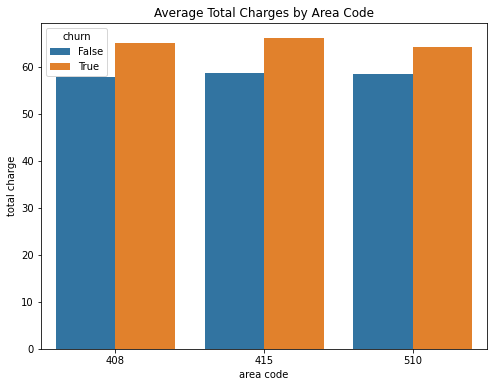

In [28]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(x=df['area code'], y=df['total charge'], hue = df['churn'], ci=None)

ax.set(title='Average Total Charges by Area Code')

plt.savefig('Average Total Charges by Area Code')

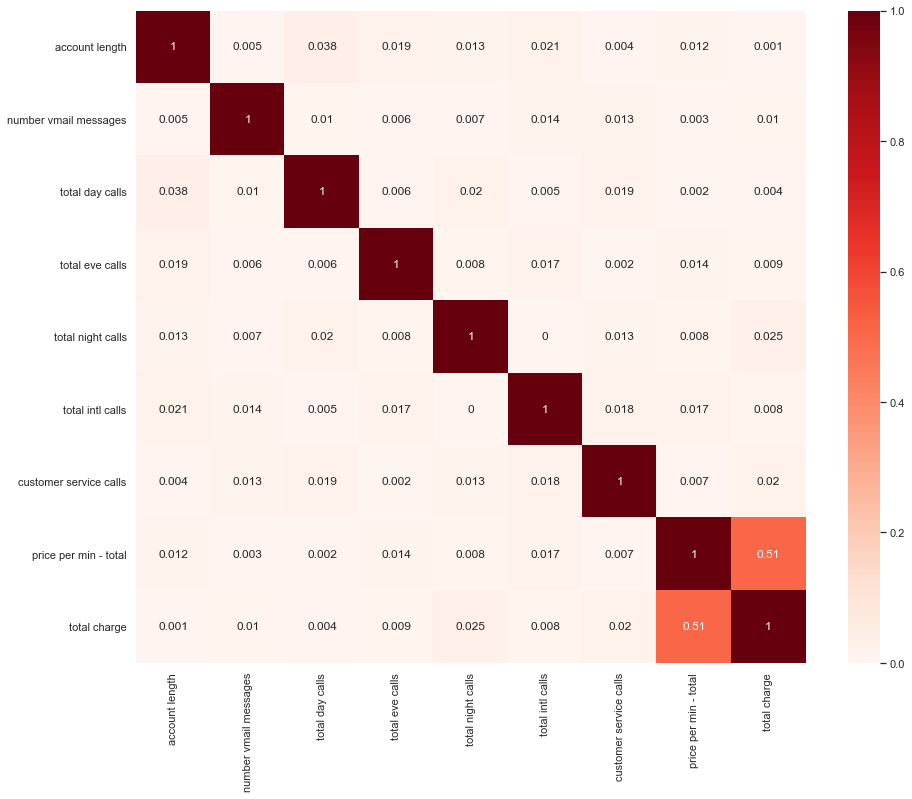

In [29]:
df_predictors = df.drop(columns=['churn','total day charge', 'total day minutes', 'total eve charge', 'total eve minutes','total night charge', 'total night minutes','total intl charge', 'total intl minutes'])
corr = round(abs(df_predictors.corr()),3)
sns.set(rc = {'figure.figsize':(15,12)})
sns.heatmap(corr, cmap="Reds", annot=True)
plt.savefig('Corr Heatmap');

Although there is some correlation between total price per min and total charge, I have decided to keep both as they could be different indicators of potential churn.

# 3. Modeling

Now that I have a better understanding of the data, data types, and have engineered some pertinent features, I begin prepping the data by creating the X and y variables, applying train/test/split to the data, creating subpipelines for numerical and categorical features, and then using the ColumnTransformer.

### _Train/Test/Split and ColumnTransformer_

In [66]:
#Setting X and Y, and applying train test split to data. Based on the correlation matrix above, 
#I dropped certain numerical columns, such as day/eve/night charges, minutes, intl minutes as they are generally included in the engineered feature (price per minute)
X = df.drop(columns = ['churn','total day charge', 'total day minutes', 'total eve charge', 'total eve minutes','total night charge', 'total night minutes','total intl charge', 'total intl minutes','total charge','phone number'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [67]:
#Create two subpipes, one for the numerical features and the other for categoricals.

subpipe_num = Pipeline(steps=[
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [68]:
CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, selector(dtype_include = np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

In [69]:
#Fit and transform X_train to CT and check the shape for any anomolies or issues with the one hot encoding
CT.fit_transform(X_train).shape

(2499, 66)

In [70]:
CT.fit_transform(X_train)[0]

array([-1.4045081 , -0.58470035,  1.33085178,  0.4013396 ,  0.00493982,
       -0.59523506, -0.42790263, -1.88163445,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ])

The shape above indicates there are 2,499 records in the train set and 67 columns, which is primarily driven by the number of unique states and the 3 unique area codes.

In [71]:
X_train.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total eve calls,total night calls,total intl calls,customer service calls,price per min - total
367,MD,45,415,no,no,0,127,108,100,3,1,0.084634
3103,DE,115,415,no,no,0,111,108,113,1,2,0.093754
549,OK,121,408,no,yes,31,63,117,85,5,4,0.106805
2531,RI,180,415,no,no,0,134,113,87,4,1,0.097896
2378,OR,112,510,no,no,0,122,94,101,7,3,0.112185


### _Pipeline and Cross Validation - Attempt #1_

Next, I use the class code below (taken from Lecture #51 at FlatIron) to run cross validation for each model pipeline that I instantiate.

In [72]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
    
    def cvmean(self):
        cvmean2 = round(self.cv_mean,3)
        print(cvmean2)

I then instantiate each of the various model types using a pipeline and the ColumnTransformer, beginning with the Dummy Classifier. The other model types I consider include:
 - Logistic Regression
 - Random Forest Classifier
 - Gradient Boost Classifier
 - Decision Tree
 - K Nearest Neighbors
 - Ada Boost Classifier

In [73]:
dummy_model_pipe = Pipeline(steps= [
    ('ct', CT),
    ('dum', DummyClassifier(strategy = 'most_frequent'))
])

dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy model', X_train, y_train)

In [74]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

logreg_pipe = ModelWithCV(logreg_model_pipe,'logreg_model', X_train, y_train)

In [75]:
rfc_model_pipe = Pipeline([
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state = 42))
])

rfc_pipe = ModelWithCV(rfc_model_pipe,'rfc_model', X_train, y_train)

In [76]:
gbc_model_pipe = Pipeline([
    ('ct',CT),
    ('gbc',GradientBoostingClassifier(random_state = 42))
])

gbc_pipe = ModelWithCV(gbc_model_pipe,'gbc_model', X_train, y_train)

In [77]:
dt_model_pipe = Pipeline([
    ('ct',CT),
    ('dt',DecisionTreeClassifier())
])

dt_pipe = ModelWithCV(dt_model_pipe,'dt_model', X_train, y_train)

In [78]:
knn_model_pipe = Pipeline([
    ('ct',CT),
    ('knn',KNeighborsClassifier())
])

knn_pipe = ModelWithCV(knn_model_pipe,'knn_model', X_train, y_train)

In [79]:
abc_model_pipe = Pipeline([
    ('ct',CT),
    ('abc',AdaBoostClassifier())
])

abc_pipe = ModelWithCV(abc_model_pipe,'abc_model', X_train, y_train)

In [80]:
dummy_pipe.print_cv_summary()
logreg_pipe.print_cv_summary()
rfc_pipe.print_cv_summary()
gbc_pipe.print_cv_summary()
dt_pipe.print_cv_summary()
knn_pipe.print_cv_summary()
abc_pipe.print_cv_summary()

CV Results for `dummy model` model:
            0.85674 ± 0.00149 accuracy
        
CV Results for `logreg_model` model:
            0.86156 ± 0.01533 accuracy
        
CV Results for `rfc_model` model:
            0.88396 ± 0.01141 accuracy
        
CV Results for `gbc_model` model:
            0.87956 ± 0.01314 accuracy
        
CV Results for `dt_model` model:
            0.80552 ± 0.02078 accuracy
        
CV Results for `knn_model` model:
            0.85474 ± 0.00892 accuracy
        
CV Results for `abc_model` model:
            0.85595 ± 0.01404 accuracy
        


In [81]:
CV_Mean_Score = [dummy_pipe.cv_mean, logreg_pipe.cv_mean,
rfc_pipe.cv_mean,
gbc_pipe.cv_mean,
dt_pipe.cv_mean,
knn_pipe.cv_mean,
abc_pipe.cv_mean]

CV_STD = [dummy_pipe.cv_std, logreg_pipe.cv_std,
rfc_pipe.cv_std,
gbc_pipe.cv_std,
dt_pipe.cv_std,
knn_pipe.cv_std,
abc_pipe.cv_std]

Model_Type = ['Dummy Classifier', 'Logistic Regression','Random Forest Classifier','Gradient Boosting Classifier',
'Decision Tree','KNN', 'AdaBoost Classifier']

data = {'Model Type':Model_Type, 'CV Mean Score':CV_Mean_Score, 'CV STD':CV_STD}
df_score = pd.DataFrame(data)

df_score

,Model Type,CV Mean Score,CV STD
0,Dummy Classifier,0.856744,0.001493
1,Logistic Regression,0.861555,0.015332
2,Random Forest Classifier,0.883958,0.011411
3,Gradient Boosting Classifier,0.879560,0.013138
4,Decision Tree,0.805524,0.020778
5,KNN,0.854744,0.008922
6,AdaBoost Classifier,0.855947,0.014041


From the cross validation results above, we can see that the RFC and GBC models have the best CV results so far, however all the results are below .9. Therefore, I decide to make some changes and add an additional feature of 'total charge' in the next iteration of these models. 

### _Pipeline and Cross Validation - Attempt #2_

In [82]:
#Setting X and Y, and applying train test split to data. 
#I dropped certain numerical columns, such as day/eve/night charges, minutes, intl minutes as they are generally included in the engineered feature (price per minute)
#I leave in 'total charge' within the x features
X2 = df.drop(columns = ['churn','total day charge', 'total day minutes', 'total eve charge', 'total eve minutes','total night charge', 'total night minutes','total intl charge', 'total intl minutes','phone number'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=42)

In [83]:
dummy_model_pipe = Pipeline(steps= [
    ('ct', CT),
    ('dum', DummyClassifier(strategy = 'most_frequent'))
])

dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy model', X_train, y_train)

In [84]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

logreg_pipe = ModelWithCV(logreg_model_pipe,'logreg_model', X_train, y_train)

In [85]:
rfc_model_pipe = Pipeline([
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state = 42))
])

rfc_pipe = ModelWithCV(rfc_model_pipe,'rfc_model', X_train, y_train)

In [86]:
gbc_model_pipe = Pipeline([
    ('ct',CT),
    ('gbc',GradientBoostingClassifier(random_state = 42))
])

gbc_pipe = ModelWithCV(gbc_model_pipe,'gbc_model', X_train, y_train)

In [87]:
dt_model_pipe = Pipeline([
    ('ct',CT),
    ('dt',DecisionTreeClassifier())
])

dt_pipe = ModelWithCV(dt_model_pipe,'dt_model', X_train, y_train)

In [88]:
knn_model_pipe = Pipeline([
    ('ct',CT),
    ('knn',KNeighborsClassifier())
])

knn_pipe = ModelWithCV(knn_model_pipe,'knn_model', X_train, y_train)

In [89]:
abc_model_pipe = Pipeline([
    ('ct',CT),
    ('abc',AdaBoostClassifier())
])

abc_pipe = ModelWithCV(abc_model_pipe,'abc_model', X_train, y_train)

In [91]:
CV_Mean_Score = [dummy_pipe.cv_mean, logreg_pipe.cv_mean,
rfc_pipe.cv_mean,
gbc_pipe.cv_mean,
dt_pipe.cv_mean,
knn_pipe.cv_mean,
abc_pipe.cv_mean]

CV_STD = [dummy_pipe.cv_std, logreg_pipe.cv_std,
rfc_pipe.cv_std,
gbc_pipe.cv_std,
dt_pipe.cv_std,
knn_pipe.cv_std,
abc_pipe.cv_std]

Model_Type = ['Dummy Classifier', 'Logistic Regression','Random Forest Classifier','Gradient Boosting Classifier',
'Decision Tree','KNN', 'AdaBoost Classifier']

data = {'Model Type':Model_Type, 'CV Mean Score':CV_Mean_Score, 'CV STD':CV_STD}
df_score2 = pd.DataFrame(data)

df_score2

,Model Type,CV Mean Score,CV STD
0,Dummy Classifier,0.856744,0.001493
1,Logistic Regression,0.859949,0.015453
2,Random Forest Classifier,0.955584,0.012700
3,Gradient Boosting Classifier,0.961589,0.010602
4,Decision Tree,0.921171,0.015690
5,KNN,0.884355,0.012047
6,AdaBoost Classifier,0.907574,0.019015


Based on the results above, RFC and GBC had the two highest mean scores and with a difference of only .006. Therefore, I selected both for consideration using GridSearch.

# 4. GridSearch and Tuning

In [85]:
#Tuning and Cross Validating of RFC. Here we add in some of the important selection criteria for RFC.

params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__min_samples_leaf'] = [1,5,10]
params['rfc__max_depth'] = [5,7,9]
params

{'rfc__criterion': ['gini', 'entropy'],
 'rfc__min_samples_leaf': [1, 5, 10],
 'rfc__max_depth': [5, 7, 9]}

In [58]:
gs_rfc = GridSearchCV(rfc_model_pipe, params, cv=5, verbose=1)

In [59]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   38.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC799A0>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                

In [60]:
gs_rfc.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 1}

In [61]:
gs_rfc.best_score_

0.9443751503006013

In [62]:
pd.DataFrame(gs_rfc.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__criterion,param_rfc__max_depth,param_rfc__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.344045,0.030549,0.028321,0.007515,gini,5,1,"{'rfc__criterion': 'gini', 'rfc__max_depth': 5...",0.912,0.906,0.912,0.884,0.897796,0.902359,0.010555,13
1,0.332713,0.058976,0.024770,0.002604,gini,5,5,"{'rfc__criterion': 'gini', 'rfc__max_depth': 5...",0.884,0.920,0.914,0.870,0.891784,0.895957,0.018643,14
2,0.291296,0.010130,0.023121,0.001204,gini,5,10,"{'rfc__criterion': 'gini', 'rfc__max_depth': 5...",0.878,0.906,0.860,0.858,0.873747,0.875149,0.017236,16
3,0.337849,0.008500,0.025075,0.002203,gini,7,1,"{'rfc__criterion': 'gini', 'rfc__max_depth': 7...",0.924,0.930,0.946,0.914,0.915832,0.925966,0.011553,5
4,0.325670,0.017443,0.024101,0.002818,gini,7,5,"{'rfc__criterion': 'gini', 'rfc__max_depth': 7...",0.914,0.926,0.880,0.898,0.907816,0.905163,0.015516,11


In [63]:
gs_rfc.cv_results_['mean_test_score'].mean()

0.909339122689824

In [42]:
#Tuning and Cross Validating of GBC. Here we add in some of the important selection criteria for GBC.
params2 = {"gbc__criterion": ["friedman_mse", "mae", "mse"],
              "gbc__loss":["deviance","exponential"],
              "gbc__max_depth": [3,5],
              "gbc__min_samples_leaf": [3,5],
              "gbc__subsample": [0.5,0.9],
              "gbc__n_estimators": [1,10,20]}


In [43]:
gs_gbc = GridSearchCV(gbc_model_pipe, params2, cv=5, verbose=1)

In [116]:
gs_gbc.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 21.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC799A0>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                

In [118]:
gs_gbc.best_params_

{'gbc__criterion': 'friedman_mse',
 'gbc__loss': 'deviance',
 'gbc__max_depth': 3,
 'gbc__min_samples_leaf': 3,
 'gbc__n_estimators': 20,
 'gbc__subsample': 0.9}

In [45]:
gs_gbc.cv_results_['mean_test_score'].mean()

0.9170915664662659

In [46]:
gs_gbc.best_score_

0.963186372745491

# 5. Final Model Selection

After applying GridSearch to both the RFC and GBC pipelines, it seems the GBC has the higher average CV score and the higher "best score". I apply the final tuning to the GBC model based on the "best parameters" identified from the GridSearch and create our Final Model.

In [113]:
final_model = Pipeline([
    ('ct',CT),
    ('gbc',GradientBoostingClassifier(random_state = 42, criterion='friedman_mse', loss = 'deviance', max_depth=3, min_samples_leaf= 3,
    n_estimators= 20, subsample=0.9))
])

final_model.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC799A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC79B50>)])),
                ('gbc',
                 GradientBoostingClassif

In [114]:
final_model.score(X_train, y_train)

0.9651860744297719

In [99]:
final_model.score(X_test, y_test)

0.9700239808153477

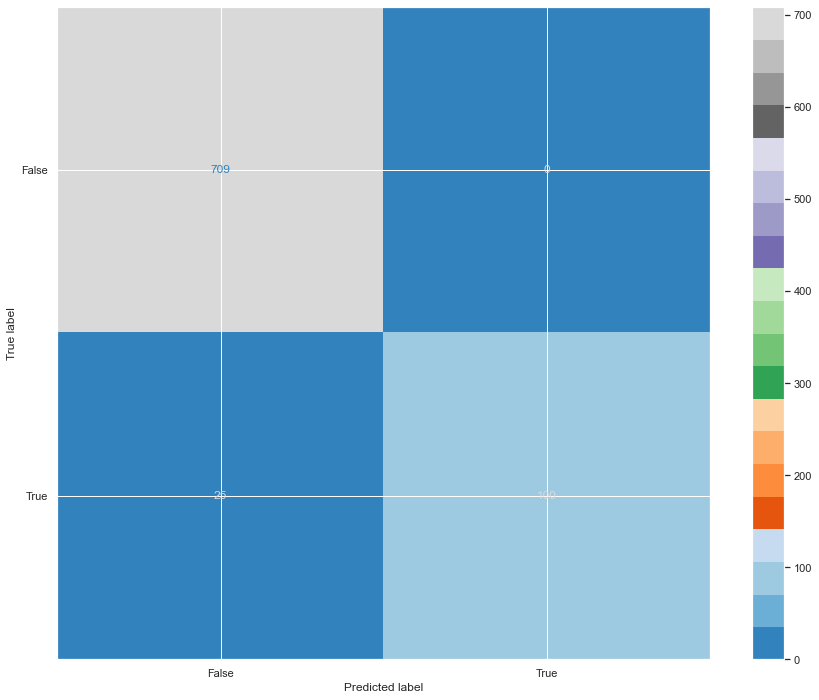

In [136]:
plot_confusion_matrix(final_model, X_test, y_test, cmap = "tab20c")

In [96]:
y_hat = final_model.predict(X_test)

print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.97. 

Our final model's recall on the test set is 0.8 

Our final model's precision on the test set is 1.0 

Our final model's f1-score on the test is 0.89.



As a final sanity check, we can apply the best paramaters to the RFC model pipeline and check the accuracy, recall, precicision and F1 scores to the GBC model above. The results show the GBC is still the better model.

In [101]:
RFC_model = Pipeline([
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state = 42,criterion='gini', max_depth=9, min_samples_leaf=1))
])

RFC_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC799A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC79B50>)])),
                ('rfc', RandomForestClassifier(max_depth=9, rand

In [102]:
RFC_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC799A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A07CC79B50>)])),
                ('rfc', RandomForestClassifier(max_depth=9, rand

In [103]:
RFC_model.score(X_train, y_train)

0.9643857543017207

In [104]:
RFC_model.score(X_test, y_test)

0.9496402877697842

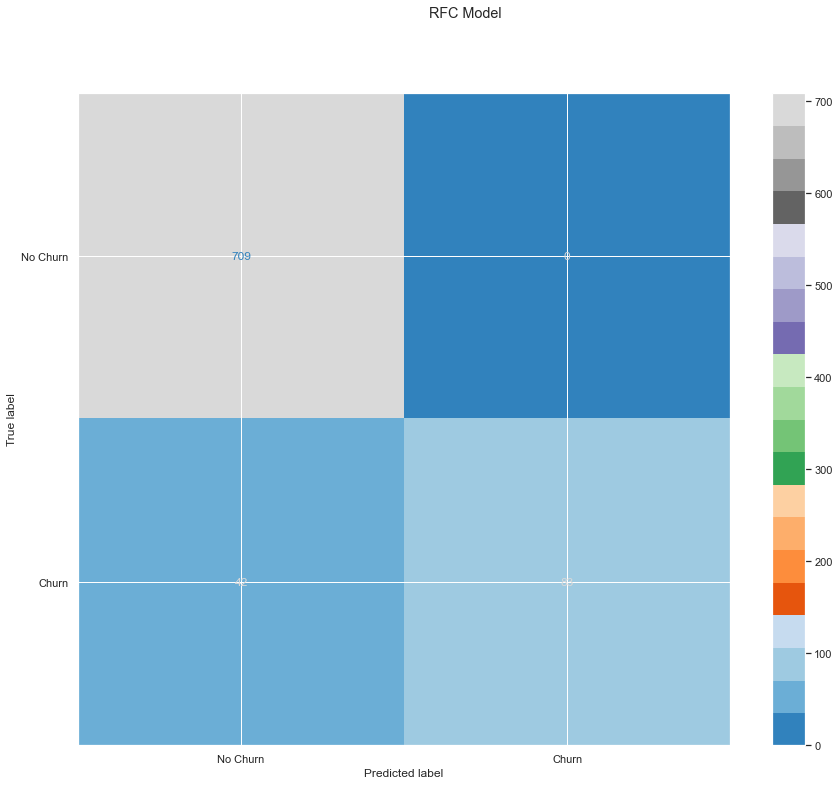

In [135]:
fig, ax = plt.subplots()

fig.suptitle("RFC Model")

plot_confusion_matrix(RFC_model, X_test, y_test, ax=ax, cmap = "tab20c", display_labels=['No Churn','Churn'] )

In [110]:
y_hat2 = RFC_model.predict(X_test)

print(f"""
Our RFC model's accuracy on the test set is {round(accuracy_score(y_test, y_hat2), 2)}. \n
Our RFC model's recall on the test set is {round(recall_score(y_test, y_hat2), 2)} \n
Our RFC model's precision on the test set is {round(precision_score(y_test, y_hat2), 2)} \n
Our RFC model's f1-score on the test is {round(f1_score(y_test, y_hat2), 2)}.
""")


Our RFC model's accuracy on the test set is 0.95. 

Our RFC model's recall on the test set is 0.66 

Our RFC model's precision on the test set is 1.0 

Our RFC model's f1-score on the test is 0.8.

